# Lab assignment: Isolation Forests

<img src="https://albarji-labs-materials.s3-eu-west-1.amazonaws.com/omaForest.jpg"/>

<div style="float: right;">(Oma Forest, Basque Country, photo by <a href=https://commons.wikimedia.org/wiki/File:Bosque_de_Oma_%2821%29.JPG>Wikipedia Commons</a>)</div>

In this assignment we will make use of the Isolation Forest method for density estimation and outlier detection tasks. We will first test this model to compute the density of an unknown distribution, and then for the everyday task of saving our lives on board of a submarine. Because lab assignments are so much fun when you might not get to survive them. ^__^

## Guidelines

Throughout this notebook you will find empty cells that you will need to fill with your own code. Follow the instructions in the notebook and pay special attention to the following symbols.

<img src="https://albarji-labs-materials.s3-eu-west-1.amazonaws.com/question.png" height="80" width="80" style="float: right;"/>

***

<font color=#ad3e26>
You will need to solve a question by writing your own code or answer in the cell immediately below or in a different file, as instructed.</font>

***

<img src="https://albarji-labs-materials.s3-eu-west-1.amazonaws.com/exclamation.png" height="80" width="80" style="float: right;"/>

***
<font color=#2655ad>
This is a hint or useful observation that can help you solve this assignment. You should pay attention to these hints to better understand the assignment.
</font>

***

<img src="https://albarji-labs-materials.s3-eu-west-1.amazonaws.com/pro.png" height="80" width="80" style="float: right;"/>

***
<font color=#259b4c>
This is an advanced exercise that can help you gain a deeper knowledge into the topic. Good luck!</font>

***

To avoid missing packages and compatibility issues you should run this notebook under one of the [recommended Ensembles environment files](https://github.com/albarji/teaching-environments-ensembles).

The following code will embed any plots into the notebook instead of generating a new window, and set the random seed.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import numpy as np
np.random.seed(42)

Lastly, if you need any help on the usage of a Python function you can place the writing cursor over its name and press Shift+Tab to produce a pop-out with related documentation. This will only work inside code cells. 

Let's go!

## Isolation Forest basics

Although the Isolation Forest algorithm is a simple modification of the Random Forest algorith, scikit-learn already implements these modifications for us, so we can easily make use of this anomaly detection model. We just need to import the **IsolationForest** class:

In [2]:
from sklearn.ensemble import IsolationForest

The IsolationForest object follows closely the interface of other machine learning methods available in scikit-learn. That means we just need to follow the usual steps of creating, fitting and then making use of the fitted model. At creation time we can also specify the different parameters of the model. Creating an IsolationForest without arguments will use the recommended values, as we can see here:

In [3]:
model = IsolationForest()
model.get_params()

{'bootstrap': False,
 'contamination': 'auto',
 'max_features': 1.0,
 'max_samples': 'auto',
 'n_estimators': 100,
 'n_jobs': None,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

The most important parameters are the number of trees in the forest (*n_estimators*) and the ratio of training data that will be regarded as outliers (*contamination*). Other parameters of interest are the maximum number of instances to use for each tree in the forest (*max_samples*), and the maximum number of training features to consider in each tree (*max_features*). We will come back later to these parameters, first let's try the Isolation Forest with a simple problem.

## Density estimation

Let us solve a simple density estimation problem. First we need data, which we will generate synthetically:

<img src="https://albarji-labs-materials.s3-eu-west-1.amazonaws.com/question.png" height="80" width="80" style="float: right;"/>

***

<font color=#ad3e26>
Create a numpy array <b>X</b> of two dimensions (a matrix), with 10000 rows and a single column. Each row should contain a random number following a gaussian distribution.

***

<img src="https://albarji-labs-materials.s3-eu-west-1.amazonaws.com/exclamation.png" height="80" width="80" style="float: right;"/>

***
<font color=#2655ad>
You can generate random numbers following a given distribution using the functions in the <a href=https://docs.python.org/3/library/random.html>random</a> module.
</font>

***

In [4]:
####### INSERT YOUR CODE HERE
import numpy as np
import random
X = np.array([[random.gauss(0, 1)] for i in range(10000)])

Let's plot the data to make sure they make sense. The following should look like a gaussian distribution:

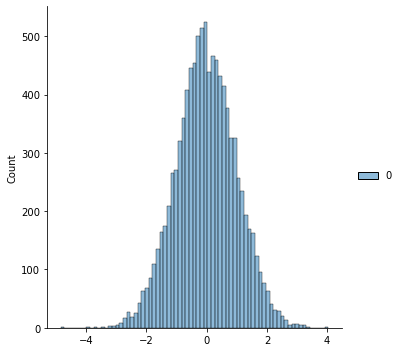

In [5]:
import seaborn as sns
sns.displot(X)

For the sake of this assignment let's assume now that we have forgotten where this data came from. You can attribute this to extreme hangover, unexpected effects of a global pandemic, or an extraterrestrial eldritch conspiracy. In such unfortunate circunstances we will make use of the Isolation Forest. First, let's train a forest with 1000 trees:

In [6]:
isoforest = IsolationForest(n_estimators=1000)
isoforest.fit(X)

IsolationForest(n_estimators=1000)

Now let's create some synthetic test data, unformly spaced between -4 and -4. We will estimate the density of the original distribution over these data points:

In [7]:
testpoints = [[x] for x in np.linspace(-4, 4, 200)]

Scikit-learn's implementation of the IsolationForest is mostly focused on anomaly detection, not on density estimation. Because of this, the IsolationForest model does not provide of a direct of way of obtaining the average depth reached by a test data point on the forest trees, which is the usual way of computing densities on a tree. It does however provide of a normalized depth in the form of the *decision_function* method. For instance, if we take a point in the center of the gaussian (0) and another point far away from it (3) we get:

In [8]:
isoforest.decision_function([[0], [3]])

array([ 0.06218021, -0.25923739])

That is, we obtain more negative values for the points corresponding to lower density. These values are actually a normalization of the average depths reached for each test point at each tree in the IsolationForest. The normalization is done in a way that negative values should be considered anomalies. Such normalization depends on the data seen at training and the contamination parameter provided. But we will cover more on this later: for now the relevant point is that these values provided by *decision_function* can be thought as "unnormalized" probability densities, and as such we can plot them for our test data as follows:

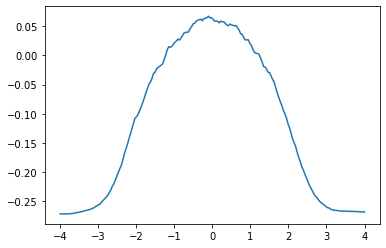

In [9]:
densities = isoforest.decision_function(testpoints)
plt.plot(testpoints, densities)

If everything has worked correctly you should be able to see something that resembles the shape of the original Gaussian distribution.

## Submarine mine hunting

<img src="https://albarji-labs-materials.s3-eu-west-1.amazonaws.com/radar.png" style="width:300px;height:300;">

Now we will apply this machine learning technique for a real world problem: spotting mines through a submarine radar. This knowledge might be useful the next time you visit your regular grocery store, so pay attention.

Our submarine is equipped with a radar that returns readings of our surroundings at different wavelengths. Whenever an object is detected, a pattern of variables is created which we need to analyze to tell whether that object is a dangerous mine or just a simple and boring rock. The problem is, enemy mines are built from a brand-new technology and we don't know what they look like. So even if we have data telling us how a rock looks like, we don't have any mine data. You might have noticed, however, how important for your near-future survival is to spot these mines.

Isolation Forests to the rescue! Let's start with the available data:

<img src="https://albarji-labs-materials.s3-eu-west-1.amazonaws.com/question.png" height="80" width="80" style="float: right;"/>

***

<font color=#ad3e26>
 Load the training data into a numpy array <b>X</b>. You can find the data as the <i>sonar.train</i> file. All patterns are unlabeled, so all variables present in the file are input features.

***

In [10]:
####### INSERT YOUR CODE HERE
import pandas as pd
data = pd.read_csv("sonar.train", delim_whitespace=True, header=None)
X = data.values

In [11]:
print("Rock training data:", X)

Rock training data: [[0.0856 0.0454 0.0382 ... 0.0102 0.0037 0.0037]
 [0.0119 0.0582 0.0623 ... 0.0073 0.003  0.0138]
 [0.0039 0.0063 0.0152 ... 0.0003 0.0053 0.0036]
 ...
 [0.0202 0.0104 0.0325 ... 0.0054 0.0073 0.0054]
 [0.0265 0.044  0.0137 ... 0.0081 0.0086 0.0095]
 [0.0333 0.0221 0.027  ... 0.0132 0.0051 0.0041]]


<img src="https://albarji-labs-materials.s3-eu-west-1.amazonaws.com/question.png" height="80" width="80" style="float: right;"/>

***

<font color=#ad3e26>
 Train an IsolationForest on the rocks data. Then generate a visualization of the distribution of unnormalized densities that are obtained when using the IsolationForest over the same training data.

***

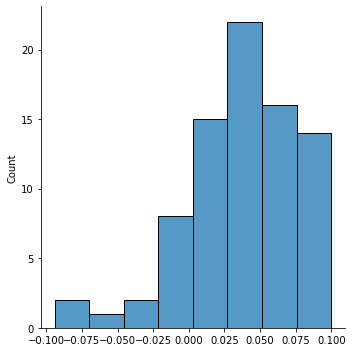

In [12]:
####### INSERT YOUR CODE HERE
isoforest = IsolationForest(n_estimators=1000)
isoforest.fit(X)
sns.displot(isoforest.decision_function(X))

If the model is correctly trained you should see that most values are positive.

<img src="https://albarji-labs-materials.s3-eu-west-1.amazonaws.com/alarm.jpg" style="width:512px;height:384;">
<center><pre>
<span style="color:#FF8080">
#################################################
### ALERT ALERT ALERT ALERT ALERT ALERT ALERT ###
#################################################
</span>
</pre></center>

There is no more time, the enemy ships are attacking! Our intelligence reports say there are **15 mines** in this sector. You must find as many as you can, or else...

<img src="https://albarji-labs-materials.s3-eu-west-1.amazonaws.com/question.png" height="80" width="80" style="float: right;"/>

***

<font color=#ad3e26>
 The file <i>sonar.test</i> contains labeled data, where boring rocks have been labeled as -1 and life-threatening mines as +1. Load the contents of this file into a numpy matrix <i>Xtest</i> containing the input features, and a list <i>ytest</i> containing the labels.

***

In [13]:
####### INSERT YOUR CODE HERE
test = pd.read_csv("sonar.test", delim_whitespace=True, header=None)
Xtest = test[test.columns[:-1]].values
ytest = test[test.columns[-1]].values

<img src="https://albarji-labs-materials.s3-eu-west-1.amazonaws.com/question.png" height="80" width="80" style="float: right;"/>

***

<font color=#ad3e26>
 Now run the test input features through the isolation forest you trained above. The 15 objects with lowest density must be the mines! Label those objects as mines and check the accuracy of your prediction! How many mines did you manage to spot?

***

<img src="https://albarji-labs-materials.s3-eu-west-1.amazonaws.com/exclamation.png" height="80" width="80" style="float: right;"/>

***
<font color=#2655ad>
You will need to use the <b>decision_function</b> method of the IsolationForest to obtain density values, sort those values to find to lowest ones, and recover which objects were assigned such values. Then you can check against <b>ytest</b> whether those object are real mines or not.</td></tr>
</font>

***

In [14]:
####### INSERT YOUR CODE HERE
def scoretestmines(model, Xtest, ytest):
    nmines = sum(ytest == 1)
    scores = model.decision_function(Xtest)
    sortedidx = [x[0] for x in sorted(enumerate(scores), key=lambda x: x[1])]
    anomaliesidx = sortedidx[:nmines]
    return sum(ytest[anomaliesidx] == 1)

scoretestmines(isoforest, Xtest, ytest)

10

## Using labeled samples

If some labeled samples are available, even if there are only a few of them, we can use them to adjust the parameters of the IsolationForest. Let's suppose we have a small sample of data from 5 mines.

<img src="https://albarji-labs-materials.s3-eu-west-1.amazonaws.com/question.png" height="80" width="80" style="float: right;"/>

***

<font color=#ad3e26>
 The file <i>mines.train</i> contains labeled data from 5 mines we can use for training. Create a new numpy array named <i>X2</i> that contains the input training data from both rocks and mines.

***

In [15]:
####### INSERT YOUR CODE HERE
mines = pd.read_csv("mines.train", delim_whitespace=True, header=None)
X2 = np.vstack([X, mines.values])

With this we have a mix of rocks and mines in the training data. We can use this mixture to choose an appropriate value for the **contamination** argument of the IsolationForest. Ideally, the contamination should be equal to the fraction of anomalies we have in our training data.

<img src="https://albarji-labs-materials.s3-eu-west-1.amazonaws.com/question.png" height="80" width="80" style="float: right;"/>

***

<font color=#ad3e26>
 Build a new IsolationForest named <i>isoforest</i>, setting the <i>contamination</i> parameter adequately. The value for this parameter should be the fraction of mines present in the training data X2. Then fit this model using X2.
    
***

In [16]:
####### INSERT YOUR CODE HERE
isoforest = IsolationForest(n_estimators=1000, contamination=len(mines)/len(X2))
isoforest.fit(X2)

IsolationForest(contamination=0.058823529411764705, n_estimators=1000)

Once we have an IsolationForest with a well-adjusted contamination ratio, we can use it to directly generate predictions on which test data points are likely to be anomalies. We can do this with the *predict* method from the IsolationForest model we just fitted:

In [17]:
isoforest.predict(Xtest)

array([ 1,  1,  1,  1,  1,  1,  1, -1,  1, -1,  1, -1, -1,  1,  1,  1,  1,
       -1,  1, -1,  1,  1,  1, -1, -1,  1, -1,  1,  1,  1, -1,  1])

The IsolationForest returns 1 for those patterns than seem normal, and -1 for those that look like anomalies. Note we have not told the IsolationForest how many mines are on the test data, it is trying to infer this quantity by itself. This should work correctly if we have provided an adequate contamination value at construction time.

<img src="https://albarji-labs-materials.s3-eu-west-1.amazonaws.com/question.png" height="80" width="80" style="float: right;"/>

***

<font color=#ad3e26>
How many mines from the test set have you succesfully detected now?
    
***

In [18]:
####### INSERT YOUR CODE HERE
preds = isoforest.predict(Xtest)
idx = np.where(preds == 1)
sum(preds[idx] == ytest[idx])

7

As a final note, the IsolationForest model does not implement a `predict_proba` method. If we need to obtain soft predictions (for instance, to plot a ROC curve), we can resort again to the `decision_function` method.

In [19]:
isoforest.decision_function(Xtest)

array([ 0.01056609,  0.06597111,  0.05890007,  0.09149199,  0.04567826,
        0.02423956,  0.10301394, -0.01902471,  0.06114532, -0.05116142,
        0.05703316, -0.08907538, -0.06424697,  0.0893662 ,  0.05111718,
        0.02656133,  0.02755688, -0.02820094,  0.03424327, -0.0072075 ,
        0.07702263,  0.07482993,  0.07756587, -0.00540903, -0.00317586,
        0.05973314, -0.00123636,  0.03841572,  0.07138552,  0.09353308,
       -0.03048994,  0.04515976])